In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed

# Read data from the file
sentences = []
labels = []

with open('english/en_fce_train.tsv', 'r', encoding='utf-8') as f:
    words = []
    curr_labels = []
    for line in f:
        if line.isspace():
            sentences.append(' '.join(words))
            labels.append(' '.join(curr_labels))
            words = []
            curr_labels = []
        else:
            word, label = line.strip().split('\t')
            words.append(word)
            curr_labels.append(label)

# Print first sentence and its corresponding label sequence
print(sentences[0])
print(labels[0])

Dear Sir or Madam ,
c c c c c


[55, 193, 58, 281]
[ 55 193  58 281   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


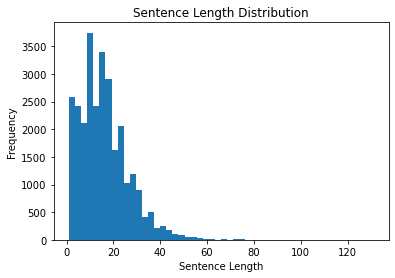

In [25]:
# Tokenize the sentences
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)

# Create word-to-index dictionary
word_index = tokenizer.word_index

# Convert sentences to sequences of indices
sequences = tokenizer.texts_to_sequences(sentences)

# Print the first sequence
print(sequences[0])

# Pad sequences to ensure fixed length
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Print the first padded sequence
print(padded_sequences[0])

# Plot the sentence length distribution
plt.hist([len(s.split()) for s in sentences], bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()

In [26]:
# Tokenize the labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

# Create label-to-index dictionary
label_index = label_tokenizer.word_index

# Convert labels to sequences of indices
label_sequences = label_tokenizer.texts_to_sequences(labels)

# Pad label sequences to ensure fixed length
padded_label_sequences = pad_sequences(label_sequences, maxlen=max_length, padding='post', truncating='post')


In [27]:
model = Sequential([
    Embedding(len(word_index) + 1, 128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    TimeDistributed(Dense(len(label_index) + 1, activation='softmax'))
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train = np.expand_dims(padded_label_sequences, -1)
history = model.fit(padded_sequences, y_train, epochs=5)

with open('english/en_fce_dev.tsv', 'r', encoding='utf-8') as f:
    words = []
    curr_labels = []
    for line in f:
        if line.strip() == '':
            test_sentences.append(' '.join(words))
            test_labels.append(' '.join(curr_labels))
            words = []
            curr_labels = []
        else:
            word, label = line.strip().split('\t')
            words.append(word)
            curr_labels.append(label)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Generate predictions
predictions = model.predict(padded_test_sequences)
predicted_labels = np.argmax(predictions, axis=-1)
predicted_labels_text = label_tokenizer.sequences_to_texts(predicted_labels)

print("Number of test sentences:", len(test_sentences))
print("Number of predicted labels:", len(predicted_labels_text))
assert len(test_sentences) == len(predicted_labels_text)

Epoch 1/5
887/887 [==============================] - 13s 12ms/step - loss: 0.0778 - accuracy: 0.9754
Epoch 2/5
887/887 [==============================] - 10s 11ms/step - loss: 0.0592 - accuracy: 0.9799
Epoch 3/5
887/887 [==============================] - 9s 11ms/step - loss: 0.0558 - accuracy: 0.9810
Epoch 4/5
887/887 [==============================] - 10s 11ms/step - loss: 0.0531 - accuracy: 0.9819
Epoch 5/5
206/206 [==============================] - 1s 4ms/step
Number of test sentences: 6573
Number of predicted labels: 6573


In [30]:
with open('english/predictions.tsv', 'w', encoding='utf-8') as f:
    for sent, labels in zip(test_sentences, predicted_labels_text):
        words = sent.split()
        pred_labels = labels.split()
        for word, label in zip(words, pred_labels):
            if label != '0':  # Skip the default padding label
                f.write(f"{word}\t{label}\n")
        f.write("\n")


Number of test sentences: 8764
Number of predicted labels: 6573


Number of test sentences: 4382
Number of predicted labels: 2191


AssertionError: 